In [1]:
from __future__ import division
from glob import glob
from collections import defaultdict
import itertools as it
from math import sqrt
import time

In [2]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter
from numpy.polynomial import polynomial as poly

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rc, cm, gridspec

In [4]:
import tracks
import otracks
import orientation as orient
import correlation as corr

In [27]:
map(reload, (tracks, otracks, orient, corr))

[<module 'tracks' from 'tracks.pyc'>,
 <module 'otracks' from 'otracks.pyc'>,
 <module 'orientation' from 'orientation.pyc'>,
 <module 'correlation' from 'correlation.py'>]

In [6]:
import helpy
reload(helpy)
from helpy import R, Nb, N, S_vid as S, A_vid as A

In [7]:
rc('font', family='serif', serif=['Latin Modern', 'Computer Modern'])
rc('text', usetex=True)
rc('savefig', dpi=192)
smallfig = (5,4)
largefig = (8,6)

In [8]:
for k in mpl.rcParams.iterkeys():
    v_current, v_default = mpl.rcParams[k], mpl.rcParamsDefault[k]
    if v_current != v_default:
        print k
        print '  current:', v_current
        print '  default:', v_default
        print '  orignal:', mpl.rcParamsOrig[k]

text.usetex
  current: True
  default: False
  orignal: False
image.origin
  current: lower
  default: upper
  orignal: lower
font.serif
  current: [u'Latin Modern', u'Computer Modern']
  default: [u'Bitstream Vera Serif', u'DejaVu Serif', u'New Century Schoolbook', u'Century Schoolbook L', u'Utopia', u'ITC Bookman', u'Bookman', u'Nimbus Roman No9 L', u'Times New Roman', u'Times', u'Palatino', u'Charter', u'serif']
  orignal: [u'Bitstream Vera Serif', u'DejaVu Serif', u'New Century Schoolbook', u'Century Schoolbook L', u'Utopia', u'ITC Bookman', u'Bookman', u'Nimbus Roman No9 L', u'Times New Roman', u'Times', u'Palatino', u'Charter', u'serif']
figure.subplot.bottom
  current: 0.125
  default: 0.1
  orignal: 0.1
figure.figsize
  current: [6.0, 4.0]
  default: [8.0, 6.0]
  orignal: [8.0, 6.0]
backend
  current: module://ipykernel.pylab.backend_inline
  default: agg
  orignal: MacOSX
savefig.dpi
  current: 192.0
  default: 100.0
  orignal: 100.0
font.size
  current: 10.0
  default: 12.0
 

In [9]:
textwidth = 80
textwidth_mark = '#' + ' '*(textwidth - 2) + '|'
char_count = ''.join((np.arange(1, textwidth + 5 + 1) % 10).astype('S1'))
print char_count
print textwidth_mark

1234567890123456789012345678901234567890123456789012345678901234567890123456789012345
#                                                                              |


In [10]:
locdir = '/Users/leewalsh/Squares/diffusion/orientational/'
savedir = '/Users/leewalsh/Squares/writing/area_overlap/'
save = True
dotfix = ''
fps = 120  # movie framerate (frames/sec)
freq = 50  # vibration freq (Hz)
#voltage = 50  # vibration amplitude (mV)
#prefix = 'n{}_{}mv_{}hz'.format(n, voltage, freq)
ns_all = np.unique([int(c[1:4]) for f in glob(locdir+'n???_ORIENTATION.npz')
                                for c in f.split('/') if c.startswith('n')])
ns = ns_all
if len(ns_all):
    print ns_all
else:
    raise IOError("No files found")

prefixer = 'n{:03d}'.format
load_data = lambda n: helpy.load_data(locdir+prefixer(n), 't o')
load_MSD = lambda n: helpy.load_MSD(locdir+prefixer(n), True, True)

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416
 424 432 440 448 456 464]


In [11]:
# alldata = {n: helpy.load_data(locdir+prefixer(n), 'p', verbose=False) for n in ns}

cum_size = 0
alldata = {}
for n in ns:
    this_data = helpy.load_data(locdir+prefixer(n), 'p', verbose=False)
    this_size = this_data.size
    this_bytes = this_size*this_data.itemsize
    cum_size += this_bytes
    print '{:3d} {:9d} {:6d}K {:6d}M - {}'.format(n, this_size, this_bytes//1024, cum_size//(1024**2), time.asctime())
    alldata[n] = this_data

 16    135833   2918K      2M - Mon May 23 19:43:53 2016
 32    251121   5395K      8M - Mon May 23 19:43:54 2016
 48    381769   8202K     16M - Mon May 23 19:43:54 2016
 64    504447  10837K     26M - Mon May 23 19:43:54 2016
 80    635879  13661K     40M - Mon May 23 19:43:54 2016
 96    751052  16135K     55M - Mon May 23 19:43:55 2016
112    883258  18976K     74M - Mon May 23 19:43:55 2016
128   1004915  21589K     95M - Mon May 23 19:43:56 2016
144   1125781  24186K    119M - Mon May 23 19:43:56 2016
160   1252650  26912K    145M - Mon May 23 19:43:57 2016
176   1380743  29664K    174M - Mon May 23 19:43:58 2016
192   1495913  32138K    205M - Mon May 23 19:43:59 2016
208   1620673  34819K    239M - Mon May 23 19:43:59 2016
224   1741804  37421K    276M - Mon May 23 19:44:00 2016
240   1853370  39818K    315M - Mon May 23 19:44:01 2016
256   1969179  42306K    356M - Mon May 23 19:44:02 2016
264   2041842  43867K    399M - Mon May 23 19:44:03 2016
272   2103743  45197K    443M -

In [12]:
dtau = dt0 = 10

In [13]:
# Find Average Bulk Density for each N (average over all frames)
verbose = False
fmt = "{:9} actual = {:.3g}, total = {:.3g}, bulk = {:.3g}".format
ns = ns_all
target_margin = 2
if target_margin:
    margins = np.linspace(target_margin - 0.25, target_margin + 0.75, 101)
    margin_loop = np.append(margins, 0)
else:
    margins = np.linspace(0, 4, 51)
    margin_loop = margins
density = defaultdict(dict)
densities = defaultdict(lambda: np.zeros_like(ns, float))
densitieses = np.zeros((len(margins), len(ns)), float)
margmins = np.zeros(len(ns), int)
if not verbose:
    print 'beginning', time.asctime()
for ni, n in enumerate(ns):
    if verbose:
        print '\nn =', n, time.asctime()
    else:
        print n,
    d = alldata[n]
    pts = helpy.consecutive_fields_view(d, 'xy')
    nf = np.count_nonzero(np.bincount(d['f']))
    bkC = None
    for mi, margin in enumerate(margin_loop):
        bn, bmask, bkC, bkR = corr.bulk(pts, margin=margin, full_N=n*nf, center=bkC,
                                        radius=R, ss=S, verbose=verbose and verbose - 1)
        Nb_margin = Nb(margin)*nf
        bnm = bn/Nb_margin
        if verbose:
            print fmt("Counts:",  n,   len(pts)/nf,   bn/nf)
            print fmt("Density:", n/N, len(pts)/N/nf, bnm)
        density[margin][n] = bnm
        densities[margin][ni] = bnm
        if margin or not target_margin:
            densitieses[mi, ni] = bnm
if target_margin:
    target_densities = densitieses.min(axis=0)
    density[target_margin] = dict(np.stack([ns, target_densities]).T)
    densities[target_margin] = target_densities
density = dict(density)
densities = dict(densities)
if not verbose:
    print '\nfinished ', time.asctime()

beginning Mon May 23 19:45:04 2016
16 32 48 64 80 96 112 128 144 160 176 192 208 224 240 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 finished  Mon May 23 19:47:08 2016


In [15]:
# print repr(target_densities)
target_margin = 2
target_densities = np.array(
      [ 0.02420206,  0.06680936,  0.10109577,  0.12144565,  0.175377  ,
        0.19286261,  0.2143604 ,  0.27084957,  0.2792175 ,  0.30315054,
        0.34317901,  0.38327158,  0.40286561,  0.43735203,  0.462506  ,
        0.50165937,  0.51473653,  0.52665151,  0.54610342,  0.57008318,
        0.56194347,  0.58175622,  0.59514894,  0.61449694,  0.62483666,
        0.63690905,  0.64184274,  0.66596864,  0.68031611,  0.69119251,
        0.69856464,  0.71367553,  0.72632263,  0.74876812,  0.76138492,
        0.7949486 ,  0.8101662 ,  0.82051109,  0.84051302,  0.85161523,
        0.87516772,  0.89285096])
density[target_margin] = dict(np.stack([ns, target_densities]).T)
densities[target_margin] = target_densities

array([ 0.02420206,  0.06680936,  0.10109577,  0.12144565,  0.175377  ,
        0.19286261,  0.2143604 ,  0.27084957,  0.2792175 ,  0.30315054,
        0.34317901,  0.38327158,  0.40286561,  0.43735203,  0.462506  ,
        0.50165937,  0.51473653,  0.52665151,  0.54610342,  0.57008318,
        0.56194347,  0.58175622,  0.59514894,  0.61449694,  0.62483666,
        0.63690905,  0.64184274,  0.66596864,  0.68031611,  0.69119251,
        0.69856464,  0.71367553,  0.72632263,  0.74876812,  0.76138492,
        0.7949486 ,  0.8101662 ,  0.82051109,  0.84051302,  0.85161523,
        0.87516772,  0.89285096])


In [16]:
print N, S, R
step = 7
ns = ns_all
print ns[::step]
print ns[::step]/N
print densities[0][::step]
print densitieses[0, ::step]

525.027980455 22.6454322917 12.9275518449
[ 16 128 240 304 360 416]
[ 0.03047457  0.24379653  0.45711849  0.57901676  0.68567774  0.79233872]
[ 0.02893161  0.24002263  0.45562058  0.57722552  0.68567571  0.79090662]
[ 0.02882782  0.27084957  0.47033798  0.58923203  0.69065693  0.80118665]


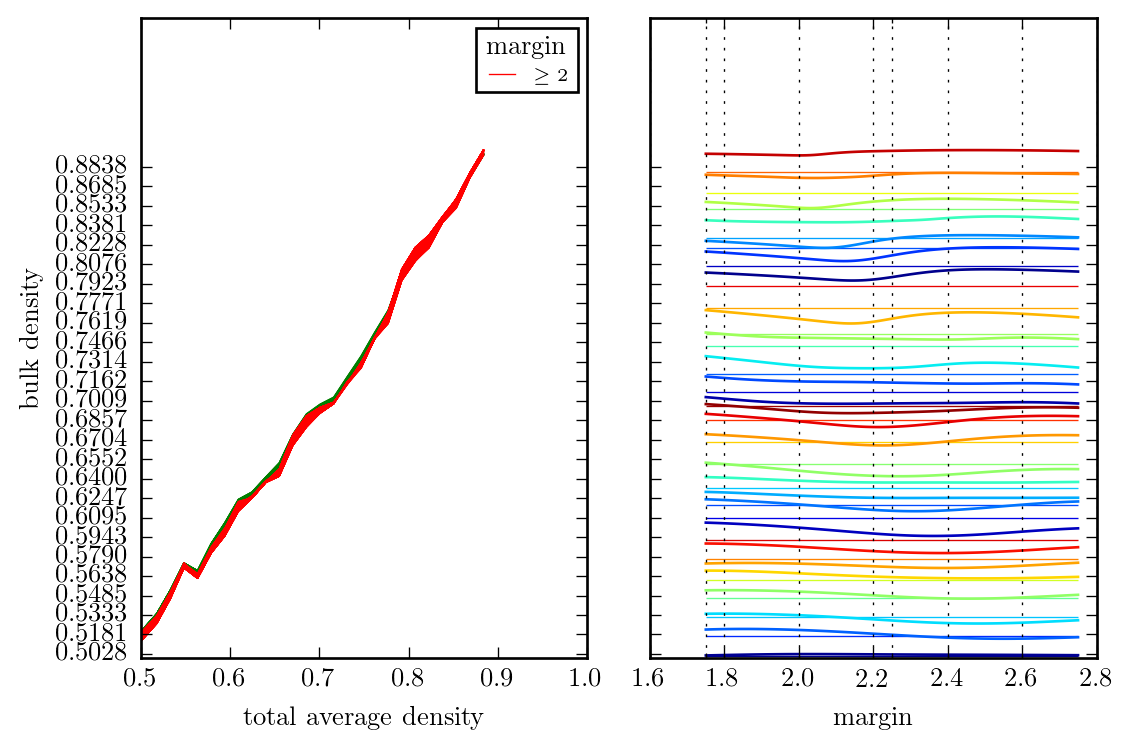

In [34]:
# Plot bulk densities with different margins
fig, (lax, rax) = plt.subplots(ncols=2, sharey=True)
total_dens = ns/N
for margin in margins:
    lax.plot(total_dens, densities[margin], lw=0.5, label='{:.1g}'.format(margin),
             color=('bgrcmyk'*2)[int(margin)])
for densities_row in densitieses.T:
    rax.plot(margins, densities_row, color=cm.jet(densities_row[0]*10 % 1))
try:
    rax.hlines(densities[0], margins.min(), margins.max(), lw=0.5,
               colors=cm.jet(densities[0]*10 % 1))
except KeyError:
    print 'nope'
rax.grid(True, axis='x', which='both')
rax.set_xticks(np.arange(margins.min(), margins.max(), 0.5), minor=True)

handles, labels = map(np.array, lax.get_legend_handles_labels())
hl_ind = margins == margins.astype('i')
lax.legend(handles[hl_ind], map(r'$\ge{}$'.format, [l for l in labels[hl_ind]]),
           loc='best', title='margin', fontsize='x-small')
lax.set_xlabel('total average density')
lax.set_ylabel('bulk density')
lax.set_yticks(ns/N)
lax.set_xlim(0.50, 1.00)
lax.set_ylim(0.50, 1.00)
#rax.legend(total_dens.astype('S3'), loc='best', title='total average density', fontsize='x-small')
rax.set_xlabel('margin')
if save:
    fig.savefig(savedir + 'density_v_margin_diffusion.pdf')

In [17]:
margin = 2
full_range = True
if full_range:
    dmin, dmax = 0.0, 0.90
else:
    dmin, dmax = densities[margin].min(), densities[margin].max()
print dmin, dmax
col = lambda dens: cm.jet((dens - dmin)/(dmax - dmin))

0.0 0.9


# MSDs

In [18]:
def diff_const(taus, msd, tau_start=None, tau_end=None,
               msd_err=None, fit=True, nargs=1):
    if tau_start == 'min': tau_start = np.argmin(msd/taus)
    if tau_end  ==  'min': tau_end  =  np.argmin(msd/taus)
    start = np.searchsorted(taus, tau_start) if tau_start else None
    end = np.searchsorted(taus, tau_end) if tau_end else None
    if fit:
        return curve_fit(powerlaw, taus[start:end], msd[start:end],
                         [1]*nargs, msd_err[start:end], True)
    else:
        mt = msd[start:end]/taus[start:end]
        w = 1/msd_err[start:end] if msd_err is not None else None
        d  = np.average(mt, weights=w)
        dd = np.average((mt - d)**2, weights=w)
        return d, dd

    
def powerlaw(t, d, b=1, c=0):
    """
    params:
    d prefactor
    b exponent
    c offset
    """
    return c + d * np.power(t, b)


def chained_power(t, d1, d2, b1=1, b2=1, c1=0, c2=0, ret_crossover=False):
    p1 = powerlaw(t, d1, b1, c1)
    p2 = powerlaw(t, d2, b2, c2)
    cp = np.maximum(p1, p2)
    if ret_crossover:
        ct = t[np.abs(p1-p2).argmin()]
        print ct
        ct = np.power(d1/d2, np.reciprocal(b2-b1))
        print ct
        return cp, ct
    else:
        return cp

    
def cage_time(taus, msd, msd_err=None):
    nargs = 3 # 2 for prefactor, 2 more for exponent.
              # 1 for exponent (nargs=3) forces one section to be diffusive.
    cpopt, cpcov = curve_fit(chained_power, taus, msd, [1]*nargs, msd_err)
    d1, d2, b1 = cpopt
    ct = np.power(d1/d2, np.reciprocal((b2 if nargs > 3 else 1)-b1))
    return cpopt, ct

In [19]:
# time: frames -> shakes; MSD & MSD_err: sq pixels -> particle area
units = {'T': [[fps/freq], [A], [A]],
         'R': [[fps/freq], [1], [1]]}

def diffusion_coeff(ns, msds, tau_lims, dim):
    ds, bs, ctopts, cts, dds, dbs = [],[],[],[],[],[]
    for n in ns:
        taus, msd, msd_err = msds[str(n)] / units[dim]
        d, dd = diff_const(taus, msd, tau_lims[0], tau_lims[1], msd_err, fit=True)
        if len(np.atleast_1d(d)) > 1:
            d, b = d
            dd, db = np.diag(dd)
            bs.append(b)
            dbs.append(np.sqrt(db))
        ds.append(d)
        dds.append(np.sqrt(dd))
        if dim == 'T':
            ctopt, ct = cage_time(taus, msd, msd_err)
            ctopts.append(ctopt)
            cts.append(ct)
    ret = [ds, dds, bs, dbs, ctopts, cts]
    return map(np.squeeze, ret)

In [20]:
def plot_msds(ns, msds, dim, ds, cts=None, ax=None, tn=0, dsd=0, llslope=False,
              label_curves=False, crop_time=False):
    if ax is None:
        fig, ax = plt.subplots()
    dsd = dsd**2 / units[dim][1][0]  # uncert in squared disp (in pixels)
    if llslope:
        llfig, llax = plt.subplots()
    for ni, n in enumerate(ns):
        taus, msd, msd_err = msds[str(n)] / units[dim]
        dens = density[margin][n]
        c = col(dens)
        ax.plot(taus, (msd-dsd)/taus**tn, c=c, label=format(dens, '.3f'))
        if dim == 'T':
            ctopts = ds[ni]
            ax.plot(taus, chained_power(taus, *ctopts)/taus**tn, '--', lw=.5, c=c)
            if cts is not None:
                ax.plot(cts[ni], chained_power(cts[ni], *ctopts)/cts[ni]**tn,
                        'o', c=c, mec='none')
        elif dim == 'R':
            ax.plot(taus, powerlaw(taus, ds[ni])/taus**tn, '--', lw=.5, c=c)
        if llslope:
            msd_smooth = gaussian_filter(msd, 50, mode='nearest')
            llx, lls = helpy.loglog_slope(taus, msd_smooth)
            llax.plot(llx, lls, c=c)
            diffusive = np.abs(lls-1) < .2
            llax.plot(llx[diffusive], lls[diffusive], '.', c=c)
            llax.set_ylim(0, 2)
        if label_curves:
            label_loc = (msd/taus).argmin()
            x = taus[label_loc]
            y = msd[label_loc] / x**tn
            ax.text(x, y, n, color=c)
    # plot the first one, times three, to show 'slope=1' guideline
    #ax.plot(taus, 3*powerlaw(taus, ds[0]), 'k--')
    ax.set_yscale('log')
    ax.set_xscale('log')
    tunit = 'seconds' if fps>1 else 'image frames'
    yunit = {'T': r'$\ell^2{0}$' if A>1 else '$pixels^2{0}$',
             'R': 'rad$^2{0}$'}
    yunit = yunit[dim].format((' / '+tunit) if tn else '')
    ylabel = 'Squared {}Displacement{} ({})'.format(
                'Angular '*(dim == 'R'), ' / Time'*bool(tn), yunit)
    #ax.set_xlabel(r'Time ({})'.format(tunit), fontsize='x-large')
    ax.set_xlabel('$tf$', fontsize='x-large')
    ax.set_ylabel(ylabel, fontsize='x-large')

    ylim = {'T': (.05, 1) if tn==1 else (.02, 70),
            'R': (.2, 200) if tn else (.05, 9e2 if crop_time else 9e3)}
    ax.set_xlim(dtau*freq/fps, 500 if crop_time else taus[-1])
    ax.set_ylim(ylim[dim])
    #ax.legend(loc='lower right', ncol=3, frameon=False, fontsize='small')

In [21]:
def plot_diffusion_coeff(dens, ds, dds, dim, bs=None, ax=None, flip=True, crit=False, legend=False):
    ylim = {'T': (0, 1000 if flip else .02),
            'R': (0,  170 if flip else .36)}
    marker = {'T': 'o', 'R': '^'}
    unit_label = {'T': r'$\ell^2f$', 'R': r'rad$^2f$'}
    label = '${0}D_{2}$ ({0}{1})'.format('1/'*flip, unit_label[dim], dim)
    color = {'T': 'b', 'R': 'g'}

    if ax is None:
        ax, fig = plt.subplots(figsize=(8, 6))
    if flip:
        ds = np.reciprocal(ds)
        dds = dds*ds*ds  # maintain same relative error: d(1/f)/(1/f) = df/f  => d(1/f) = df/(f*f)
        if bs:
            bs = np.reciprocal(bs)
    if crit:
        popt, pcov = corr.critical_power(dens, ds, tc=1, a=1, df=dds/ds, abs_df=True)
        print dim + ' opt:', popt, 'err:', np.sqrt(np.diag(pcov))
        if crit == 'subtract':
            dens = popt[0] - dens
    ax.errorbar(dens, ds, dds, ls='', marker=marker[dim], markersize=5, label=label, color=color[dim])
    if crit == 'subtract':
        ax.set_xscale('log')
        ax.set_yscale('log')
        xlim = np.array(ax.get_xlim())
        pow_fit = corr.shift_power(popt[0] - xlim, *popt)        
        ax.plot(xlim, pow_fit, color=color[dim], lw=0.5)
        ylim = {'T': (50, 1500 if flip else .02),
                'R': ( 4,  200 if flip else .36)}
    elif crit == 'show':
        ax.axvline(popt[0], lw=0.5, linestyle='-', alpha=1, color=mpl.cm.gray(.5), zorder=0.1)
    if len(bs):
        ax.errorbar(dens, bs, dbs, fmt='.', label='b')
    ax.set_ylim(ylim[dim])
    ax.set_xlabel(r"$\rho_c - \rho$" if crit == 'subtract' else r'$\rho$')
    if legend:
        ax.legend(loc='best', fontsize='small', numpoints=1, frameon=False)
    else:
        ax.set_ylabel(label)

# Translational MSDs

In [22]:
if True:
    # load all averaged MSDS
    MSDS = np.load(locdir + "MSDS.npz")
else:
    # calculate average of all MSDS
    MSDS = {}
    # Calculate the MSDS 
    # Translational kill thresholds:
    kill_flats = defaultdict(lambda: 0.5, # units are pixels
                        { 16: 1, 32: 3, 48: 1, 64: 0.5, 80: 1, 96: 0.2, 112: 0.7,
                         128: 0.6, 144: 1, 160: 10, 176: 1, 192: 0.4, 336: 1,
                         360: 0.1, 368: .6, 400: 0.2, 464: 0.2 })
    kill_jumps = defaultdict(lambda: 100, {})
    for n in ns_all:
        prefix = 'n{:03d}'.format(n)
        msdnpz = np.load(locdir+prefix+"_MSD.npz")
        msds = msdnpz['msds']
        if 'dt0' in msdnpz.keys():
            dt0  = msdnpz['dt0'][()] # [()] gets element from 0D array
            dtau = msdnpz['dtau'][()]
        else:
            print "assuming dt0 = dtau = 10" # ok for before dt* was saved
            dt0  = 10
            dtau = 10
        print "averaging track MSDs"
        nframes = max([np.array(msd)[:,0].max() for msd in msds]) + 1
        taus = np.arange(dtau, nframes, dtau)
        taus, msd, msd_err = tracks.mean_msd(msds, taus, errorbars=True,
                                kill_flats=kill_flats[n],
                                kill_jumps=kill_jumps[n])
        MSDS[str(n)] = np.row_stack([taus, msd, msd_err])

In [23]:
ns_T = np.asarray(MSDS.files, int); ns_T.sort()
ni_T = np.searchsorted(ns_all, ns_T)
dens_T = densities[margin][ni_T]
print ns_T
print dens_T

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
[ 0.02420206  0.06680936  0.10109577  0.12144565  0.175377    0.19286261
  0.2143604   0.27084957  0.2792175   0.30315054  0.34317901  0.38327158
  0.40286561  0.43735203  0.462506    0.50165937  0.51473653  0.52665151
  0.54610342  0.57008318  0.56194347  0.58175622  0.59514894  0.61449694
  0.62483666  0.63690905  0.64184274  0.66596864  0.68031611  0.69119251]


In [24]:
# find coeffient of diffusion
tau_lims = (10, None)
ds, dds, bs, dbs, ctopts, cts = diffusion_coeff(ns_T, MSDS, tau_lims, dim='T')

/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:690: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


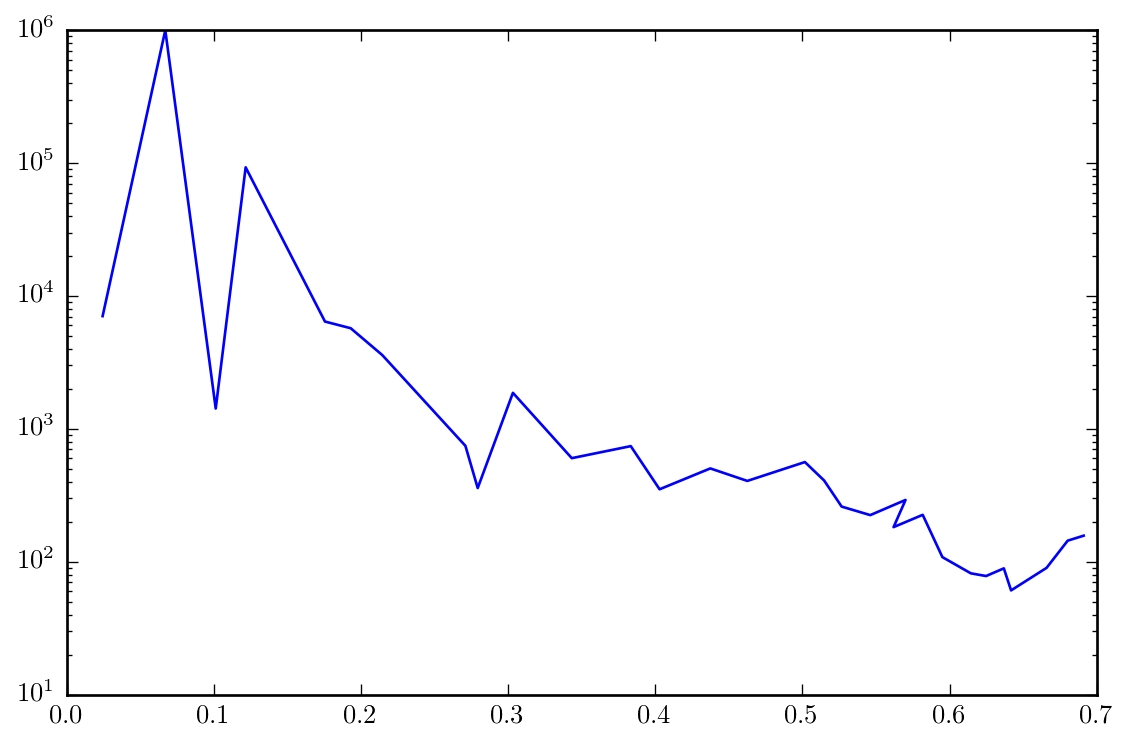

In [60]:
# plot translational diffusion caging times vs density
plt.plot(dens_T, np.clip(cts, None, 1e6))
plt.yscale('log')

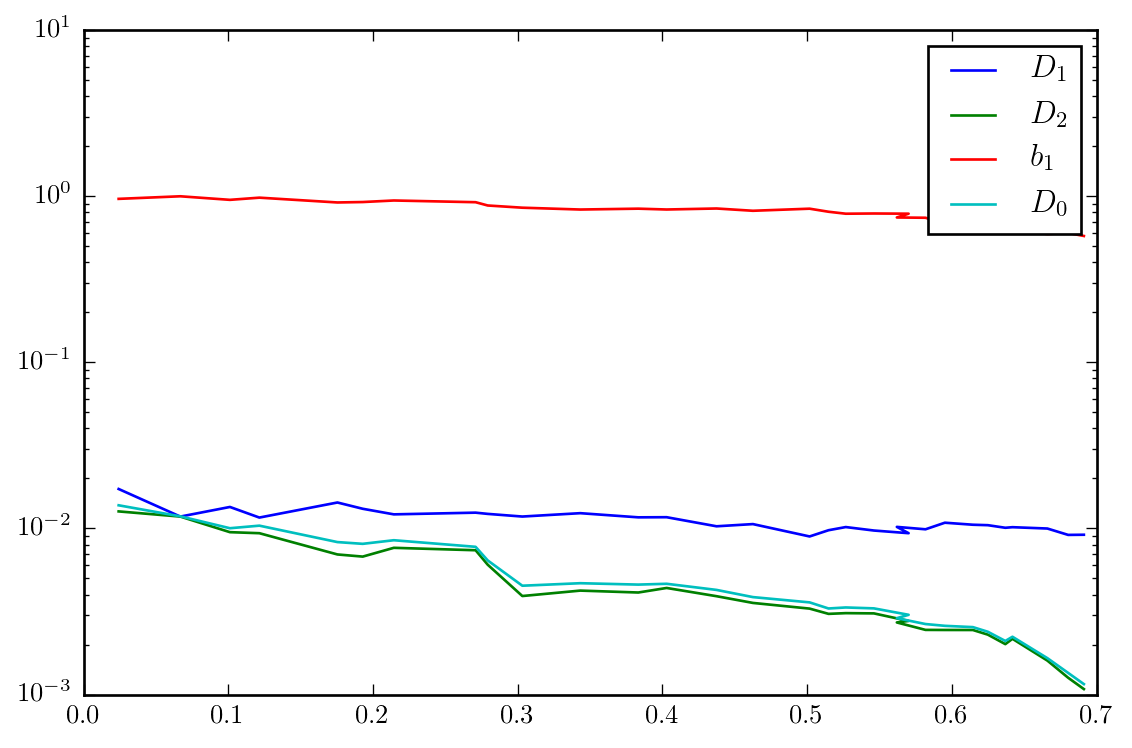

In [61]:
# plot caging time parameters
plt.plot(dens_T, ctopts)
plt.plot(dens_T, ds)
plt.legend(['$D_1$','$D_2$','$b_1$', '$D_0$'])
plt.yscale('log')

T opt: [  0.77938941  71.34968758] err: [  2.76883655e-07   1.55078317e-04]


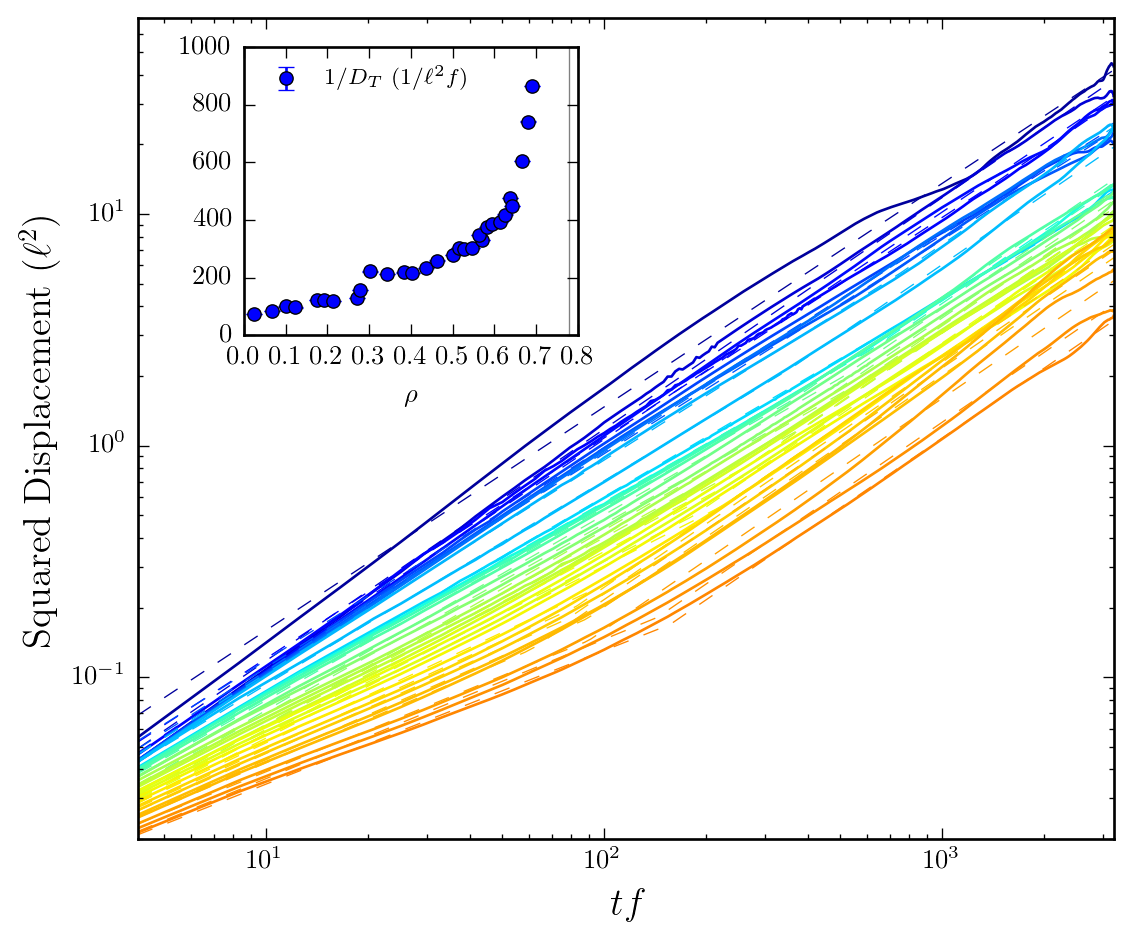

In [28]:
# Plot MSD and fits
save = True
rc('text', usetex=save)

fig, main = plt.subplots(figsize=(6, 5))
inset = fig.add_axes([.22, .64, .29, .3])
plot_msds(ns_T, MSDS, 'T', ctopts, cts=None, ax=main)
plot_diffusion_coeff(dens_T, ds, dds, dim='T', bs=bs, ax=inset, flip=True, crit='show', legend=True)

if save:
    savename = savedir + "MSDvN.pdf"
    fig.savefig(savename)

# Angular MSDs

In [30]:
if True:
    # load all averaged MSADS
    MSADS = np.load(locdir + "MSADS.npz")
else:
    # calculate average of all MSADS
    MSADS = {}
    # Angular:
    kill_flats = defaultdict(lambda: 0, {48: 5, 344: 0.03})
    kill_jumps = defaultdict(lambda: 1,
                    {16: 10, 32: 5, 48: 1, 64: 2, 80: 1, 96: 1, 344: .5, 448: 0.1,
                     456: 0.1, 464: 0.1})
    for n in ns_A:
        prefix = 'n{:03d}'.format(n)
        msadnpz = np.load(locdir+prefix+"_MSAD.npz")
        msads = msadnpz['msds']
        if 'dt0' in msadnpz.keys():
            dt0  = msadnpz['dt0'][()] # [()] gets element from 0D array
            dtau = msadnpz['dtau'][()]
        else:
            print "assuming dt0 = dtau = 10" #  should be true for all from before dt* was saved
            dt0  = 10
            dtau = 10
        print "averaging track MSADs"
        nframes = max([np.array(msad)[:,0].max() for msad in msads]) + 1
        taus = np.arange(dtau, nframes, dtau)
        taus, msad, msad_err = tracks.mean_msd(msads, taus, errorbars=True,
                                kill_flats=kill_flats[n],
                                kill_jumps=kill_jumps[n])
        MSADS[str(n)] = np.row_stack([taus, msad, msad_err])

In [31]:
ns_A = np.asarray(MSADS.files, int); ns_A.sort()
ni_A = np.searchsorted(ns_all, ns_A)
dens_A = densities[margin][ni_A]
ns_A

array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
       224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
       344, 352, 360, 368])

In [32]:
# find coeffient of angular diffusion
tau_lims = (None, 100)
das, ddas, bas, dbas, _, _ = diffusion_coeff(ns_A, MSADS, tau_lims, dim='R')

R opt: [ 0.72260249  4.75817874] err: [  2.42601500e-06   2.24763754e-04]


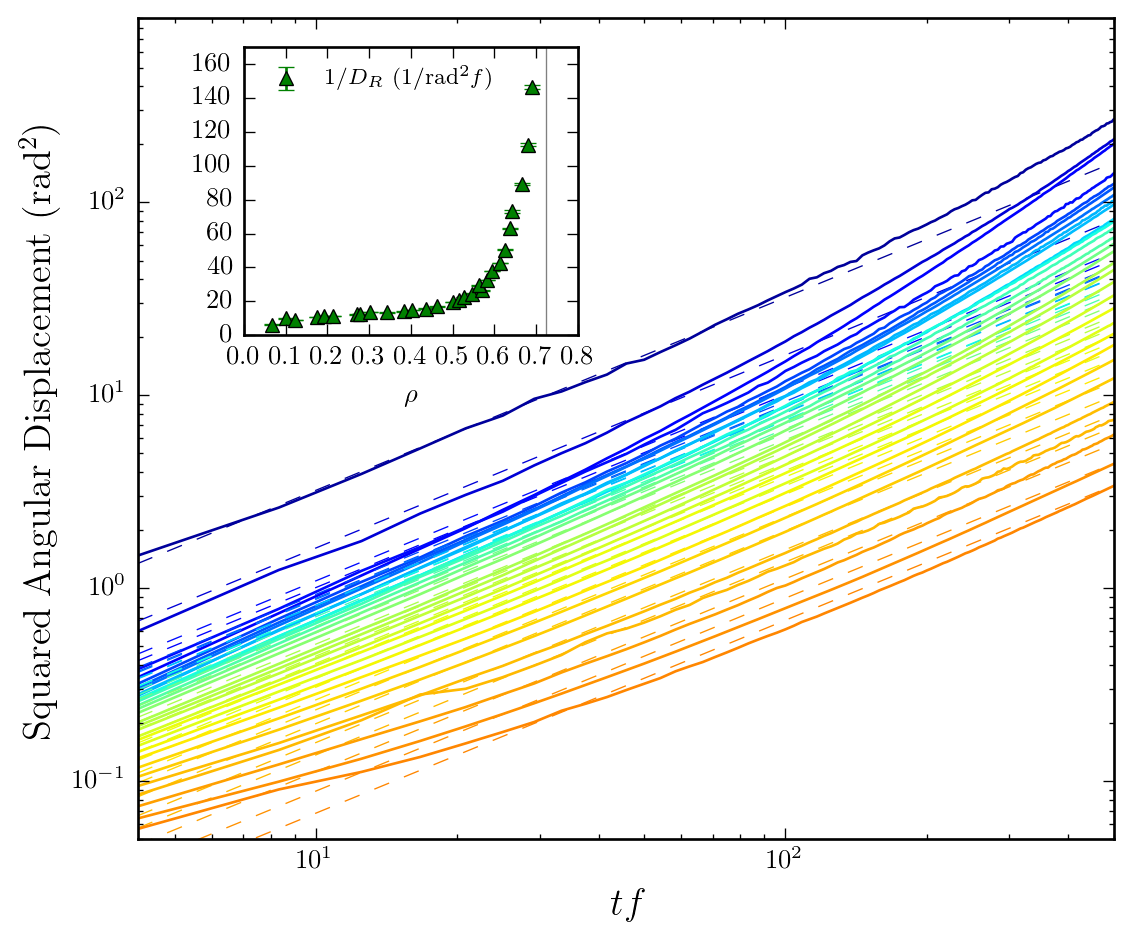

In [33]:
# Plot MSAD and fits
save = True
rc('text', usetex=save)

fig, main = plt.subplots(figsize=(6, 5))
inset = fig.add_axes([.22,.64,.29,.3])

plot_msds(ns_A, MSADS, 'R', das, cts=None, ax=main, crop_time=True)
plot_diffusion_coeff(dens_A[1:], das[1:], ddas[1:], dim='R', bs=bs, ax=inset, flip=True, crit='show', legend=True)

if save:
    savename = savedir + "MSADvN.pdf"
    fig.savefig(savename)

# Angular vs Translational diffusion

In [34]:
# densities with reliable translational _and_ angular diffusive behavior
# for looking at MSD, MSAD simultaneously
#bad_AT = [296, 328, 344, 352]
bad_A = [32, 296, 344]
bad_T = [160, 344]
min_dens = 0.
good_A = np.setdiff1d(ns_A[dens_A > min_dens], bad_A)
good_T = np.setdiff1d(ns_T[dens_T > min_dens], bad_T)
good_AT = np.intersect1d(good_T, good_A)

iAT = np.searchsorted(ns_all, good_AT)
iA = np.searchsorted(ns_A, good_AT)
iT = np.searchsorted(ns_T, good_AT)
ibadA = np.searchsorted(ns_A, bad_A)
ibadT = np.searchsorted(ns_T, bad_T)

dens_AT = densities[margin][iAT]

print ns_A
print ns_T
print ibadA
print ibadT
print good_AT
print dens_AT

[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
[ 16  32  48  64  80  96 112 128 144 160 176 192 208 224 240 256 264 272
 280 288 296 304 312 320 328 336 344 352 360 368]
[ 1 20 26]
[ 9 26]
[ 16  48  64  80  96 112 128 144 176 192 208 224 240 256 264 272 280 288
 304 312 320 328 336 352 360 368]
[ 0.02420206  0.10109577  0.12144565  0.175377    0.19286261  0.2143604
  0.27084957  0.2792175   0.34317901  0.38327158  0.40286561  0.43735203
  0.462506    0.50165937  0.51473653  0.52665151  0.54610342  0.57008318
  0.58175622  0.59514894  0.61449694  0.62483666  0.63690905  0.66596864
  0.68031611  0.69119251]


T opt: [  0.77770205  70.82160285] err: [  2.76379055e-07   1.59598047e-04]
R opt: [ 0.72230193  4.70568133] err: [  2.47792895e-06   2.35295474e-04]


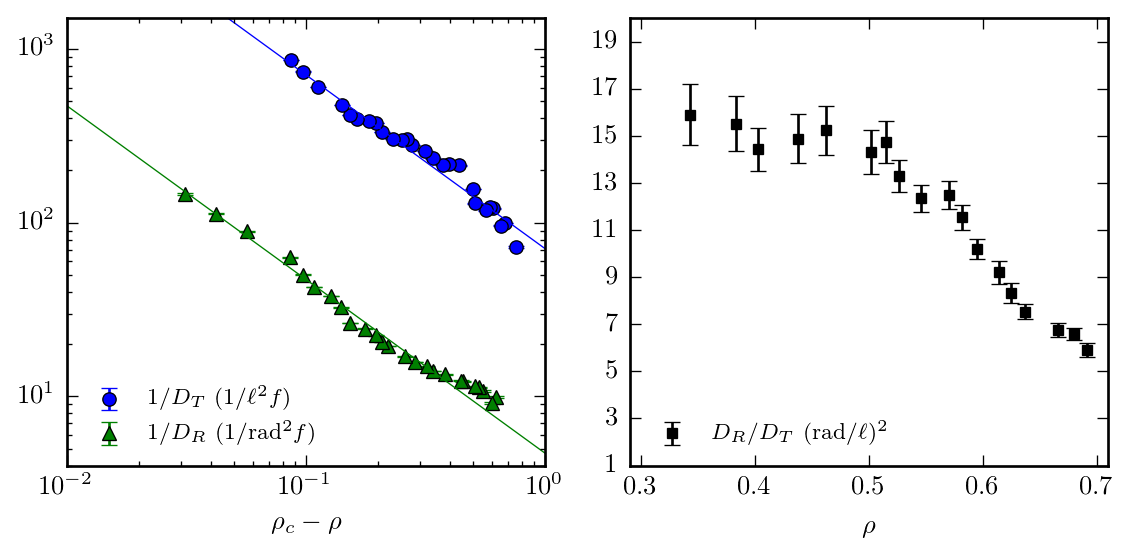

In [35]:
# Plot the Ratio of Diffusion Coefficients
# D_ratio = D_R / D_T
save = True
flip = False  # R/T unless flipped
order = 1 - 2*flip
label = '$D_{} / D_{}$ '.format(*[r'R', r'T'][::order])
label += '({}/{})$^2$'.format(*['rad', r'$\ell$'][::order])

ratio = (das[iA]/ds[iT])**order
dratio = ratio*np.sqrt((ddas[iA]/ds[iT])**2 + (dds[iT]*das[iA]/ds[iT]/ds[iT])**2)

rc('text', usetex=save)
fig, (crt, rat) = plt.subplots(figsize=(6, 3), ncols=2)
rat.errorbar(dens_AT, ratio, dratio, marker='s', markersize=4, ls='', color='k', label=label)
rat.set_xlabel(r'$\rho$')
rat.set_ylim((0, .2) if flip else (1, 20))
rat.set_xlim(.29, .71)
rat.set_yticks(range(1, 20, 2))
rat.legend(loc='lower left', fontsize='small', numpoints=1, frameon=False)

coeff_args = dict(bs=bs, ax=crt, flip=True, crit='subtract', legend=True)
plot_diffusion_coeff(dens_AT, ds[iT], dds[iT], dim='T', **coeff_args)
plot_diffusion_coeff(dens_AT, das[iA], ddas[iA], dim='R', **coeff_args)
crt.set_ylim(4, 1500)

if save:
    fig.savefig(savedir + "diffusion_constants.pdf")

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


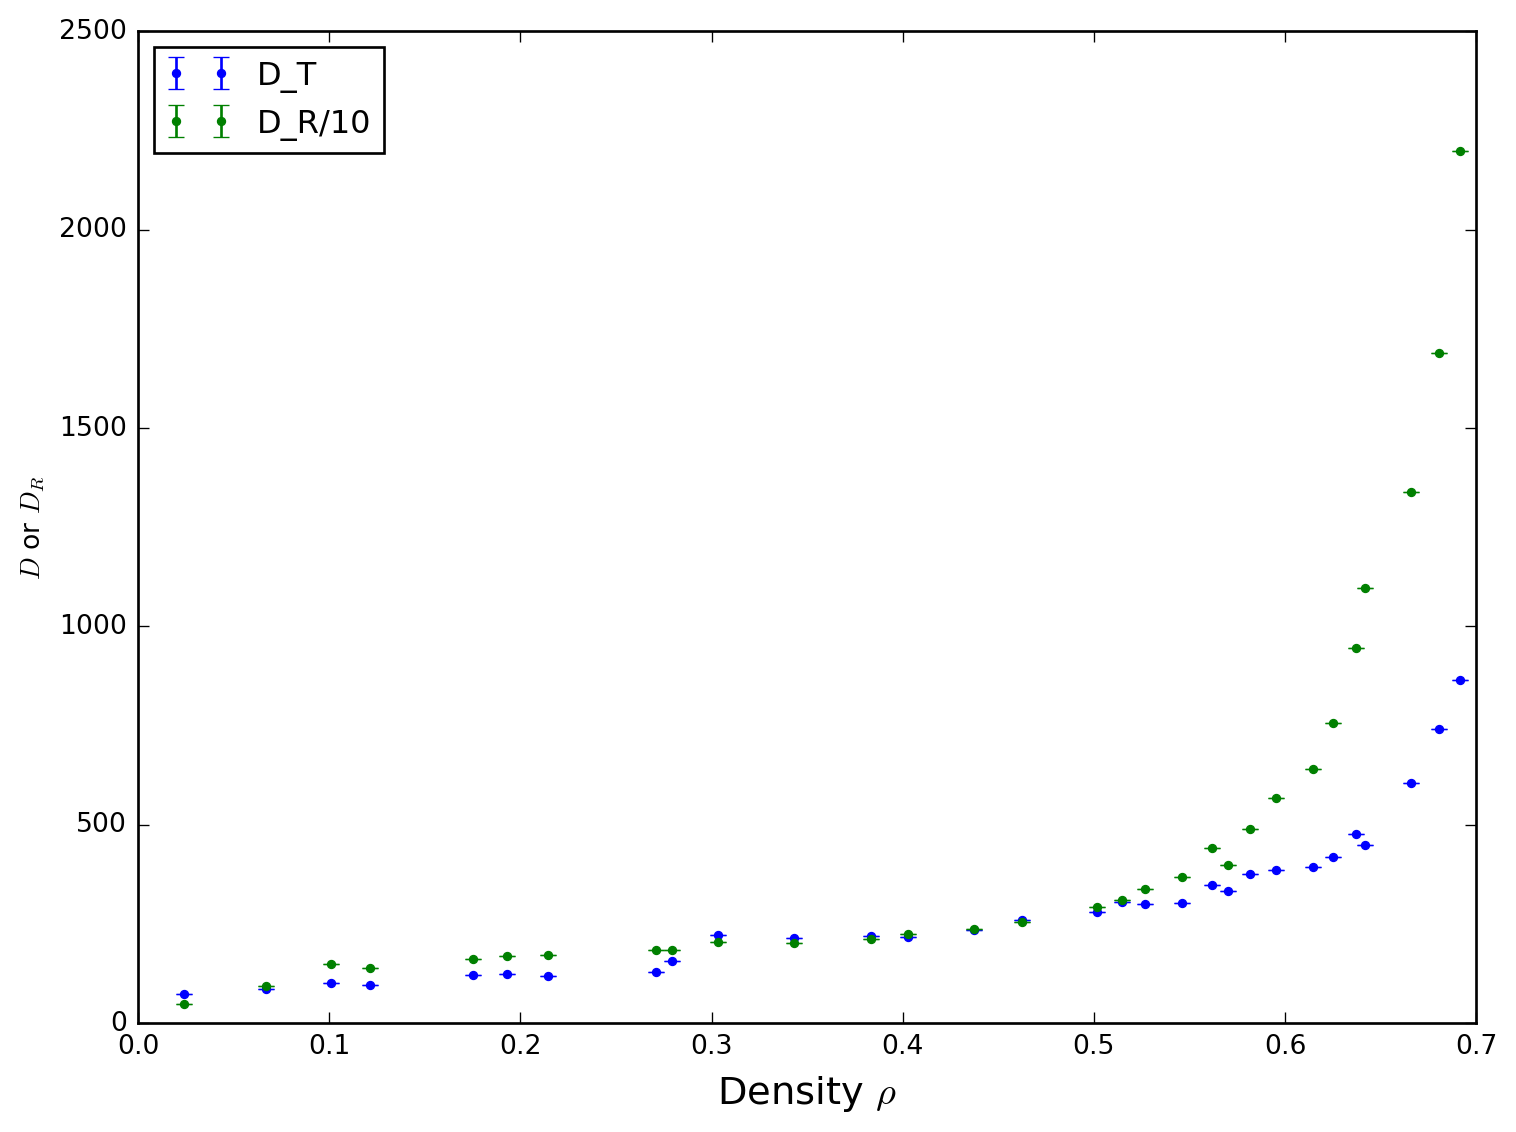

In [34]:
save = False
plt.figure(figsize=(8,6))
rc('text', usetex=save)
if bs:
    plt.errorbar(dens_T, bs, np.sqrt(dbs), fmt='.', label='b_T')
    plt.errorbar(dens_T, bas, np.sqrt(dbas), fmt='.', label='b_R')
plt.errorbar(dens_T, 1/ds, np.sqrt(dds), fmt='.', label='D_T')
plt.errorbar(dens_A, 15/das, np.sqrt(ddas), fmt='.', label='D_R/10')
plt.xlabel(r"Density $\rho$", fontsize='x-large')
plt.ylabel("$D$ or $D_R$")
#plt.ylim(0, None)#np.max(ds)*1.2)
plt.legend(loc='best')
if save: plt.savefig(savedir+'Ds.pdf')

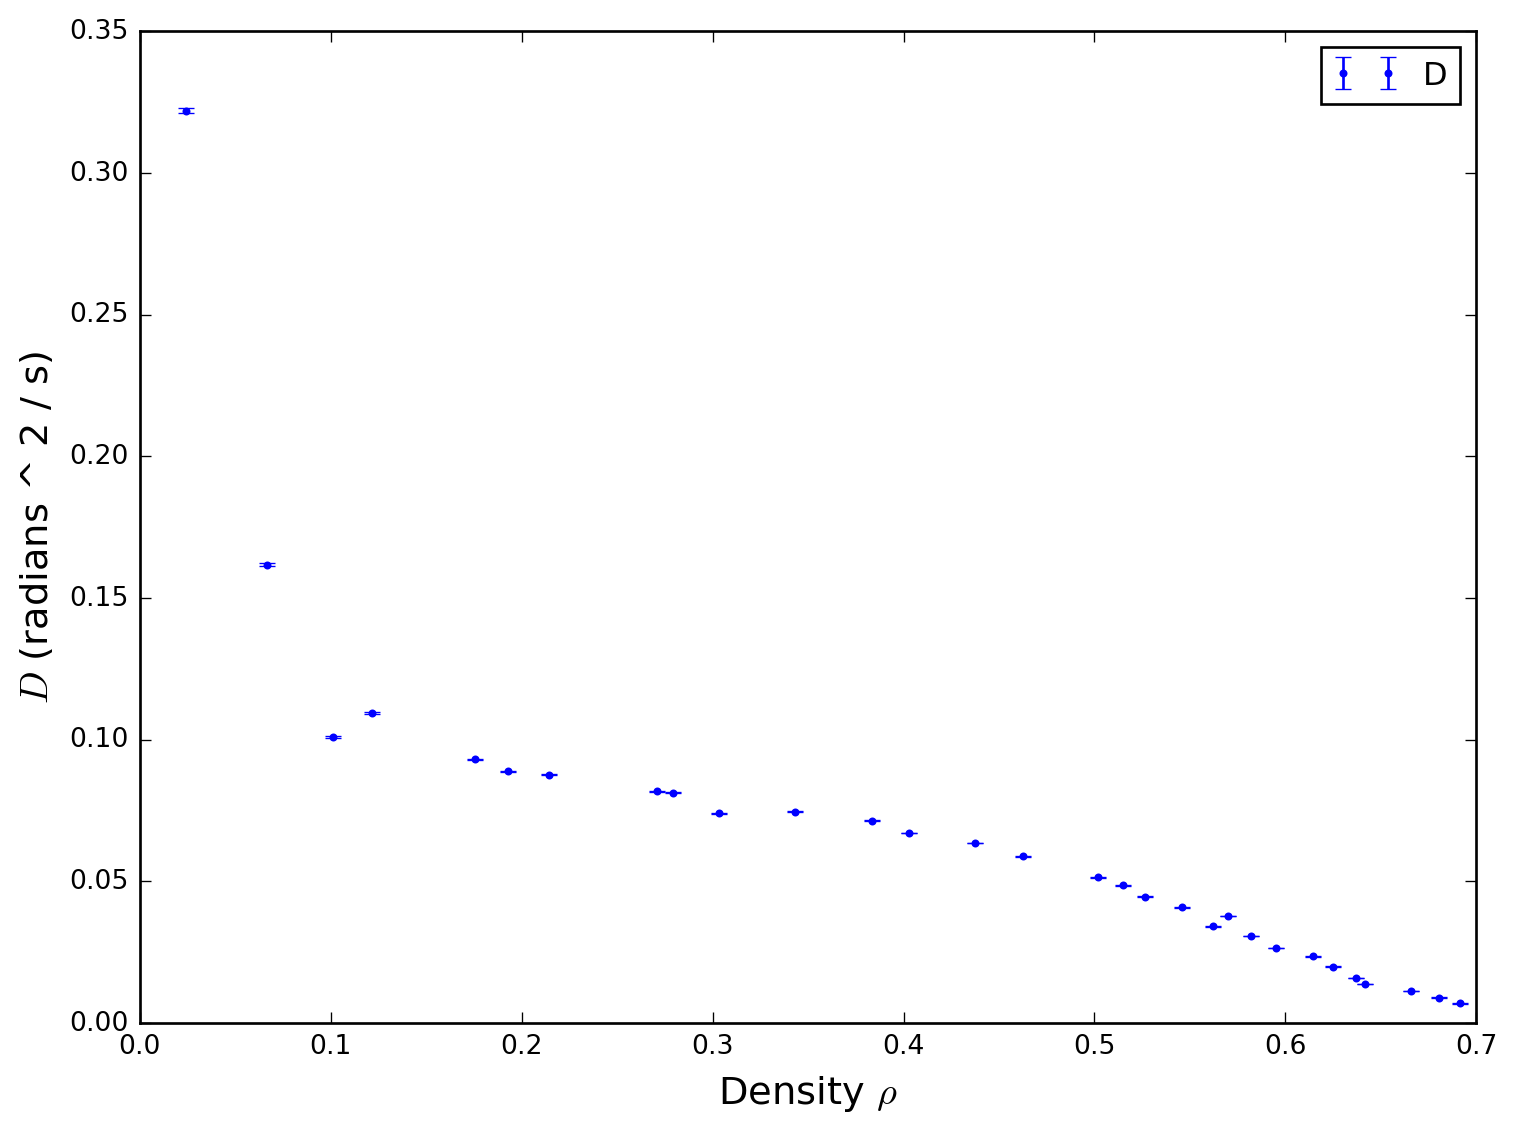

In [35]:
save = False
plt.figure(figsize=(8,6))
rc('text', usetex=save)
if bas: plt.errorbar(dens_A, bas, np.sqrt(dbas), fmt='.', label='b')
plt.errorbar(dens_A, das, np.sqrt(ddas)/fps, fmt='.', label='D', mec='none')
#plt.title("Constant of diffusion vs. density")
plt.xlabel(r"Density $\rho$", fontsize='x-large')
unit = '(radians ^ 2'
plt.ylabel("$D$ "+(unit+' / s)' if fps > 1 else unit+r"/frame)"), fontsize='x-large')
plt.ylim(0, None)#np.max(ds)*1.2)
#plt.gca().set_yscale('log')
plt.legend(loc='best')
if save: plt.savefig(locdir+"DAvN.pdf")#"DvN_dt0=%d_dtau=%d.png"%(dt0,dtau))

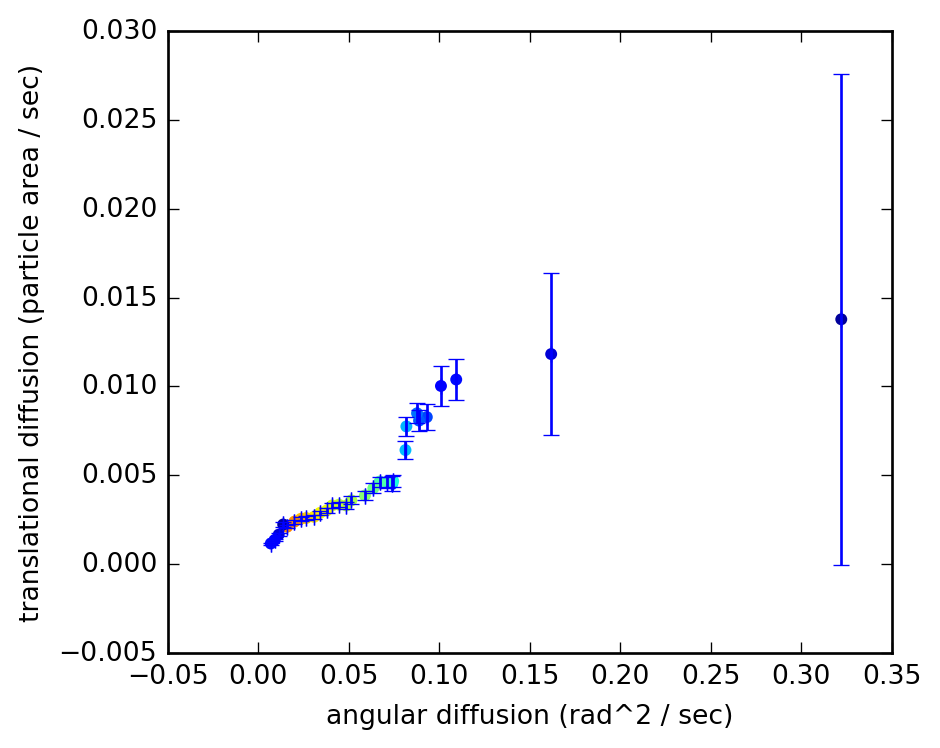

In [36]:
save = False
rc('text', usetex=save)
plt.figure(figsize=(5,4))
plt.errorbar(das, ds, ddas, dds, ls='', marker=',')
plt.scatter(das, ds, facecolor=col(dens_AT), lw=0)
#plt.xlim(0, 20)
#plt.ylim(0, .7)
plt.xlabel('angular diffusion (rad^2 / sec)')
plt.ylabel('translational diffusion (particle area / sec)')
if save: plt.savefig(savedir+'DvD.pdf')

In [36]:
if helpy.bool_input('Save the diffusion coefficients?'):
    diffusion_data = np.column_stack([ns, dens_A, ds[iT], das[iA], ratio])
    names = lambda d: d.join('N rho DT DR DR_DT'.split())
    np.savetxt('diffusion_coeffs.csv', diffusion_data, fmt='%.10f', delimiter=',', header=names(','))
    np.savetxt('diffusion_coeffs.txt', diffusion_data, fmt='%.10f', header=names(' '*8))

Save the diffusion coefficients? no


# Angle-position Correlation $\langle \vec r \hat n \rangle$

In [202]:
np.count_nonzero(np.bincount(trackids) >= 7000)

456

In [87]:
# Build up data dicts by track for all datasets
#alltracksets = {}
#allotracksets = {}
for n in ns_all[::5]:
    if n in alltracksets and n in allotracksets: continue
    data, tracksets, odata, otracksets = loadall(n, ret_msd=False) # loadall was deprecated
    alltracksets[n] = tracksets
    allotracksets[n] = otracksets

In [128]:
# Calculate all <rn> correlations
# That is, <x cos(phi)> and <y sin(phi)>
#alloxcorr = {}
#alloycorr = {}
corr_args = {'side': 'both', 'ret_dx': True, 'cumulant': True}
for n in [16, 96, 256, 376, 416, 456]:
    #if n in alloxcorr and n in alloycorr: continue
    print "{:3d}, {:5.1%}".format(n, density[2][n]),
    tracksets  = alltracksets[n]
    otracksets = allotracksets[n]
    #print [track for track in tracksets.keys()]
    #print [len(tracksets[track]) for track in tracksets.keys()]
    alloxcorr[n] = {track: corr.crosscorr(tracksets[track]['x']/S,
                                               np.cos(4*otracksets[track]), **corr_args)
                         for track in tracksets.keys() if len(tracksets[track]) >= 1000}
    alloycorr[n] = {track: corr.crosscorr(tracksets[track]['y']/S,
                                               np.sin(4*otracksets[track]), **corr_args)
                         for track in tracksets.keys() if len(tracksets[track]) >= 1000}
    print "... done!"

  16,  2.8% ... done!
 96, 19.5% ... done!
256, 50.3% ... done!
376, 68.5% ... done!
416, 76.3% ... done!
456, 85.7% ... done!


In [207]:
#Save the <rn> correlations
alloxcorr[96][1]

(array([-3850, -3849, -3848, ...,  3847,  3848,  3849]),
 array([ 0.00814488,  0.00855668,  0.00838561, ...,  0.01607229,
         0.015782  ,  0.01552884]))

<type 'numpy.ndarray'>
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.0241697884401
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.00637683269532
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.0130753748315
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.078832903545
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): 0.00206405691787
(399,) (399,) (399,)
bounds: 0 10
trange: -82.9166666667 82.9166666667 (399,)
tlims:  0 10
max corr (approx v0/D_R): -0.0415764405996


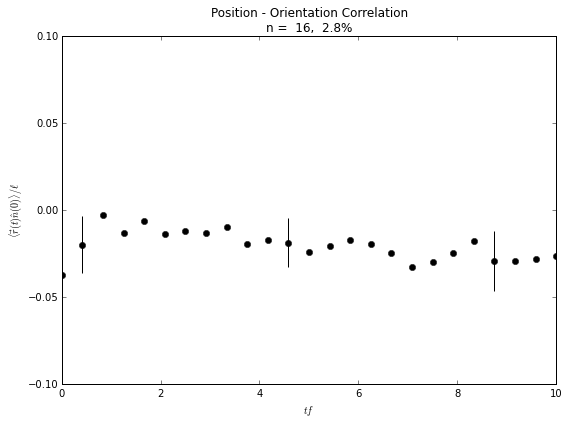

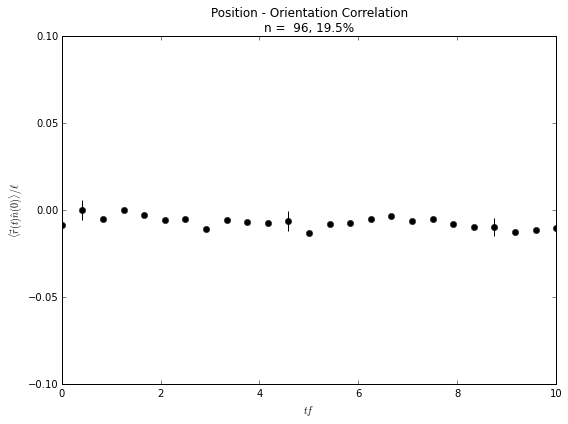

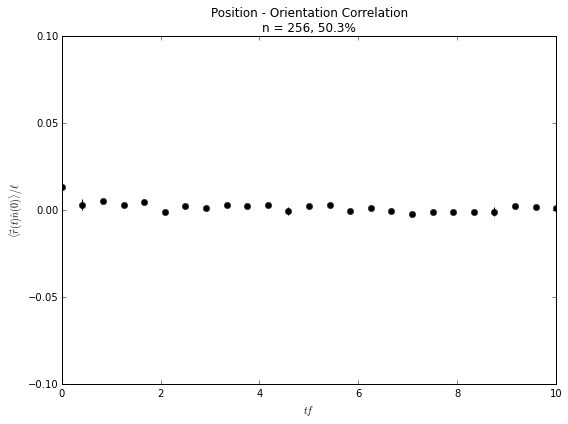

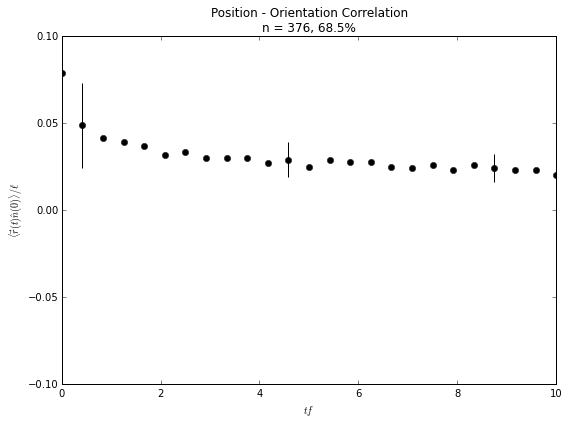

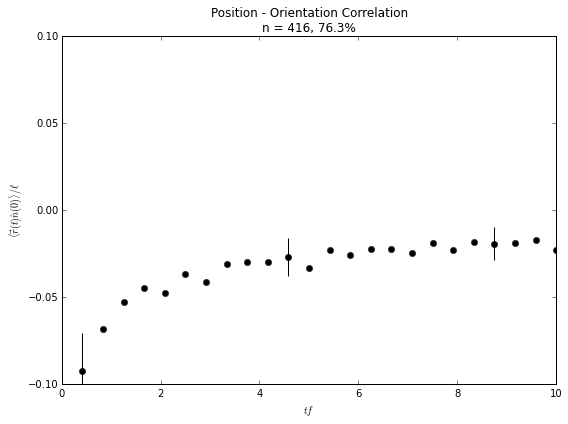

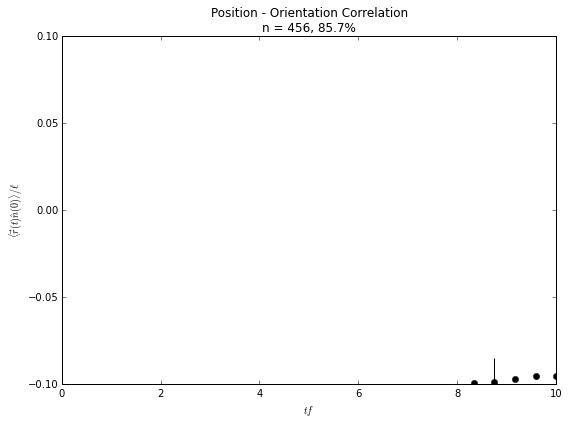

In [146]:
# Average, Fit and plot <rn> correlation
do_fit = False
save = False
rc('text', usetex=save)
print type(allcorr)
nframes = 200
tcorr = np.arange(nframes)*freq/fps
for n in sorted(alloxcorr):
    allcorr = []
    plt.figure(figsize=smallfig if save else largefig)
    prefix = n
    for track in allotracksets[prefix]:
        if len(allotracksets[prefix][track]) < 1000: continue
        tcorr = alloxcorr[prefix][track][0]
        index = np.abs(tcorr) < nframes
        oxcorr = alloxcorr[prefix][track][1][index]
        oycorr = alloycorr[prefix][track][1][index]
        tcorr = tcorr[index]*freq/fps
        allcorr.append(oxcorr)
        allcorr.append(oycorr)
        #plt.plot(tcorr, oxcorr, 'g', alpha=.25)
        #plt.plot(tcorr, oycorr, 'b', alpha=.25)
    allcorr = helpy.pad_uneven(allcorr)
    meancorr = np.nanmean(allcorr, 0)
    errcorr = np.nanstd(allcorr, 0)/sqrt(len(allcorr))
    err_offset = np.abs(errcorr.mean())
    tmin, tmax = 0 if corr_args['side']=='right' else 0, 0 if corr_args['side']=='left' else 10
    print tcorr.shape, meancorr.shape, errcorr.shape
    plt.errorbar(tcorr, meancorr, errcorr, None, 'ok', capthick=0, elinewidth=1, errorevery=10)
    xlims = max(tmin, tcorr.min()), min(tmax, tcorr.max())
    print "bounds:", tmin, tmax
    print "trange:", tcorr.min(), tcorr.max(), tcorr.shape
    print "tlims: ", xlims[0], xlims[1]
    plt.xlim(*xlims)
    #plt.ylim(1e-2, 2)

    print 'max corr (approx v0/D_R):', meancorr.max()

    if do_fit:
        fmin = np.searchsorted(tcorr, 0)
        fmax = np.searchsorted(tcorr, tmax)
        print 'flims: ', fmin, fmax
        print 'fitlims: ', tcorr[fmin], tcorr[fmax]
        fitform = corr.powerlaw
        #fitform = lambda s, v_D, dx0=0, D=D_R: v_D*(1 - corr.exp_decay(s-dx0, 1/D))
        p0 = [1, 1]
        popt, pcov = curve_fit(fitform, tcorr[fmin:fmax], meancorr[fmin:fmax],
                               p0=p0, sigma=err_offset + errcorr[fmin:fmax]
                               )
        print "\nFits:"
        print '\n'.join(['time: {:.1f}', 'amp: {:.3f}', 'offset: {:.3f}'][:len(popt)]).format(*popt)
        fit = fitform(tcorr, *popt)
        plt.plot(tcorr, fit, 'r', lw=2,
                     label='$t_0$: {:.3f}, $A$: {:.3f}'.format(*popt)
                    )
        pguess = {
                 16: (1, 0),
                 96: (1, 0),
                 256:(1, 0),
                 376:(1,.2),
                 416:(2,.4),
                 456:(2,.5),
        }
        #guess = fitform(tcorr, *pguess[n])
        #plt.plot(tcorr, guess, 'y', lw=2,
        #             label=r'$A e^{t/t_0}$'+'\n'+
        #                    '$t_0$: {:.3f}, $A$: {:.3f}'.format(*pguess[n])
        #            )
    plt.ylim(-.1, .1)
    plt.xlim(*xlims)
    #plt.yscale('log'); plt.ylim(1e-3,.5)
    #plt.xscale('log'); plt.xlim(1, xlims[1])
    plt.title("Position - Orientation Correlation\n"
              "n = {:3d}, {:5.1%}".format(n, density[2][n]))
    plt.ylabel(r"$\langle \vec r(t) \hat n(0) \rangle / \ell$")
    plt.xlabel("$tf$")
    plt.legend(loc=0, framealpha=1)

# Tracks

In [ ]:
nframes = data['f'].max() + 1
nframeso = data['f'][omask].max() + 1

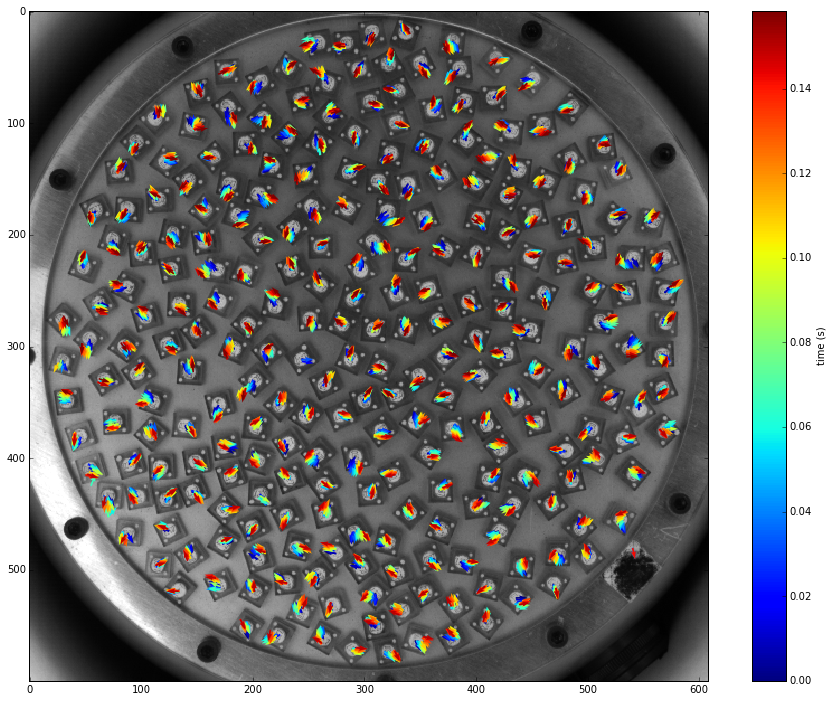

(<matplotlib.quiver.Quiver at 0x10baf63d0>,
 <matplotlib.colorbar.ColorbarBase instance at 0x10baf3f80>)

In [8]:
orient.plot_orient_quiver(data[:5000], odata[:5000], omask[:5000], imfile=locdir+prefix+'_0001.tif', fps=120,
                          figsize=(16,12), savename='')#savedir + 'quiver_tracks.png')

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


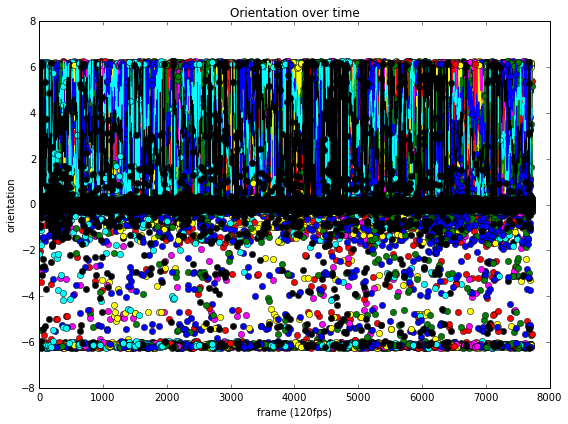

In [7]:
orient.plot_orient_time(data,odata,trackids,delta=True)#,simplify=True)

tracks used are set([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34])


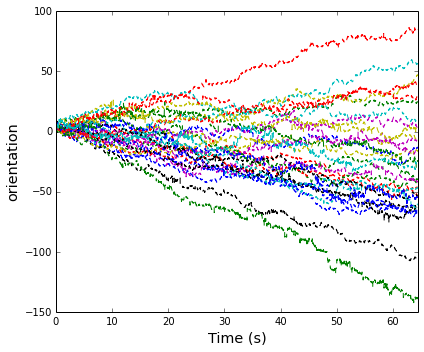

In [151]:
orient.plot_orient_time(data, odata, trackids, fps=fps, delta=False, save='savedir' + orient_tracking.pdf')

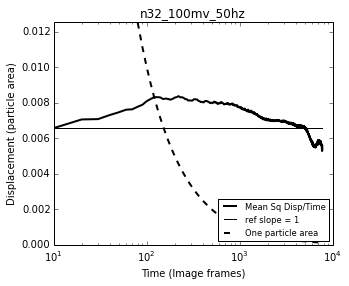

In [92]:
tracks.plot_msd(msds, msdids, dtau, dt0, nframes, prefix=prefix, tnormalize=1)

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to /Users/leewalsh/Physics/Squares/writing/graphics/MSAD.pdf


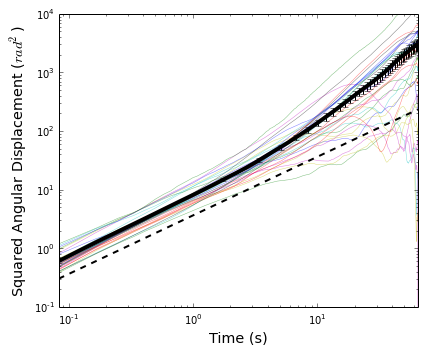

(array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
        1000, 1010, 1020, 1030, 1040, 1050, 1060, 1070, 1080, 1090, 1100,
        1110, 1120, 1130, 1140, 1150, 1160, 1170, 1180, 1190, 1200, 1210,
        1220, 1230, 1240, 1250, 1260, 1270, 1280, 1290, 1300, 1310, 1320,
        1330, 1340, 1350, 1360, 1370, 1380, 1390, 1400, 1410, 1420, 1430,
        1440, 1450, 1460, 1470, 1480, 

In [237]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, prefix=prefix, errorbars=20,
                 fps=fps, S=S, ang=True, show_tracks=True, figsize=(6,5), meancol='k', title="", lw=4,
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save=savedir + 'MSAD.pdf')

using dtau = 10, dt0 = 10
Rough coefficient of diffusion: 8.14727780692
Rough diffusion timescale: 0.166666666667
saving to ../writing/graphics/MSAD.pdf


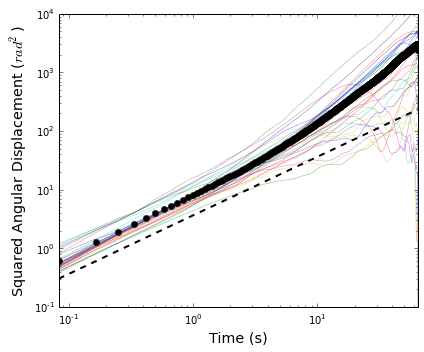

In [146]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, prefix=prefix,
                 fps=fps, S=S, ang=True, show_tracks=True, figsize=(6,5), meancol='k', title="",
                 xlim=(dtau/fps, 64), ylim=(1e-1,1e4), save='')#savedir + 'MSAD.pdf')

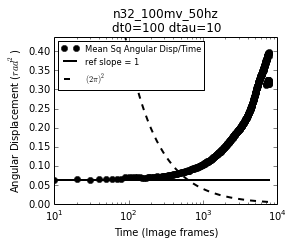

In [89]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, tnormalize=1, ang=True, prefix=prefix, show_tracks=False)

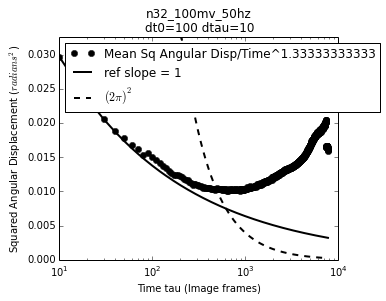

In [47]:
tracks.plot_msd(msads, msadids, dtau, dt0, nframeso, tnormalize=4./3, ang=True, prefix=prefix, show_tracks=False)

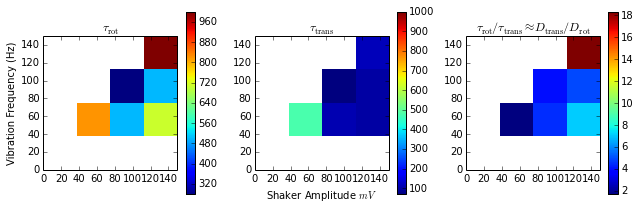

In [165]:
tau_trans = np.array([[ np.nan, np.nan, np.nan, np.nan],
                      [ np.nan, 480.,     110.,   100.],
                      [ np.nan, np.nan,    70.,   100.],
                      [ np.nan, np.nan, np.nan,   120.]])

tau_rot = np.array([[ np.nan, np.nan, np.nan, np.nan],
                    [ np.nan,   820.,   500.,   710.],
                    [ np.nan, np.nan,   280.,   500.],
                    [ np.nan, np.nan, np.nan,  2200.]])

plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(tau_rot,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{rot}$")
plt.ylabel('Vibration Frequency (Hz)')
plt.colorbar()
plt.subplot(132)
plt.imshow(tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest',vmax=1000.)
plt.title(r"$\tau_\mathrm{trans}$")
plt.xlabel('Shaker Amplitude '+r'$mV$')
plt.colorbar()
plt.subplot(133)
plt.imshow(tau_rot/tau_trans,origin='lower',extent=(0,150,0,150),interpolation='nearest')
plt.title(r"$\tau_\mathrm{rot}/\tau_\mathrm{trans}\approx D_\mathrm{trans}/D_\mathrm{rot}$")
plt.colorbar()
plt.savefig(savedir + 'D_f_A.pdf')

#Order Parameters

In [60]:
ns_all, ns

(array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464]),
 array([ 16,  32,  48,  64,  80,  96, 112, 128, 144, 160, 176, 192, 208,
        224, 240, 256, 264, 272, 280, 288, 296, 304, 312, 320, 328, 336,
        344, 352, 360, 368, 376, 384, 392, 400, 408, 416, 424, 432, 440,
        448, 456, 464]))

In [21]:
freq = 50

In [22]:
if True:
    Phi_npz = np.load(locdir+'phi_t.npz')
    Phi = {n: Phi_npz[str(n)] for n in ns_all}
else:
    Phi = {}
    for n in ns_all:
        data, trackids, odata, omask = load_data(n)
        Phi[n] = np.array([corr.orient_op(o['orient'], d[['x','y']].view((float,2)).copy()
                                          , m=4, margin=2, ret_complex=False)
                  for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                      helpy.splitter(odata[omask], data['f'][omask]))])
    np.savez(locdir + 'phi_t.npz', **{str(n): Phi[n] for n in ns_all})

In [85]:
np.savetxt(locdir+'all_phi_t', np.column_stack([Phi[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

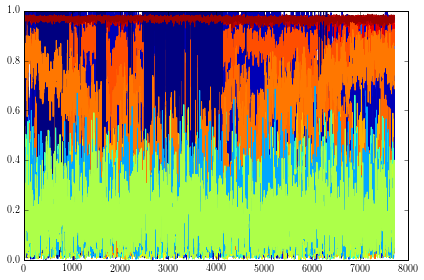

In [198]:
for n, P in reversed(Phi.items()):
    plt.plot(P, color=col(density[margin][n]))

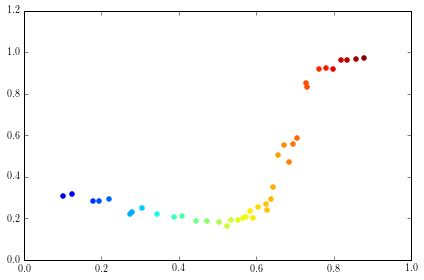

In [199]:
for n in ns_all:
    plt.scatter(density[margin][n], Phi[n].mean(), color=col(density[margin][n]))

In [23]:
nframes = len(Phi[16])

In [24]:
Phi_ac = {n: corr.autocorr(P) for n, P in Phi.iteritems()}

In [248]:
np.savetxt(locdir+'all_phiphi_newcorrfunc', np.column_stack([Phi_ac[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [269]:
# Fit to poly_exp
Phi_ac_pe = {}
for n, Pac in Phi_ac.iteritems():
    x = np.arange(len(Pac))
    if not np.all(np.isfinite(Pac)):
        print n, 'not all finite'
        continue
    try:
        p, _ = curve_fit(corr.poly_exp, x, Pac, [1,1,1])
        Phi_ac_pe[n] = corr.poly_exp(x, *p)
    except RuntimeError:
        continue

16 not all finite
32 not all finite


In [249]:
# Gaussian smooth (low-pass)
Phi_ac_lp = {}
for n, Pac in Phi_ac.iteritems():
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Phi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

In [25]:
Phi_ac_vg = { n: corr.vary_gauss(Pac, .1*np.arange(len(Pac))+.001*np.arange(len(Pac))**2) for n, Pac in Phi_ac.iteritems()}

In [189]:
Phi_ac_vg_a = { n: corr.vary_gauss(Pac, .1*np.arange(len(Pac))+.001*np.arange(len(Pac))**2) for n, Pac in Phi_ac.iteritems()}

In [190]:
Phi_ac_vg_b = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()}

In [260]:
Phi_ac_vg_c = { n: corr.vary_gauss(Pac, (0, .1, .0002)) for n, Pac in Phi_ac.iteritems()}

In [264]:
Phi_ac_vg_d = { n: corr.vary_gauss(Pac, (0, .2, .0002)) for n, Pac in Phi_ac.iteritems()}

In [266]:
Phi_ac_vg_e = { n: corr.vary_gauss(Pac, .1) for n, Pac in Phi_ac.iteritems()}

In [207]:
Phi_ac_vg_l = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()} # /len(ko)

In [210]:
Phi_ac_vg_1 = { n: corr.vary_gauss(Pac, (0, .1, .001)) for n, Pac in Phi_ac.iteritems()}

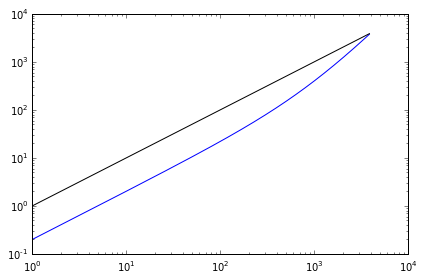

In [263]:
plt.loglog(poly.polyval(np.arange(3864), (0,.2,2e-4)))
plt.loglog(np.arange(3864), 'k')

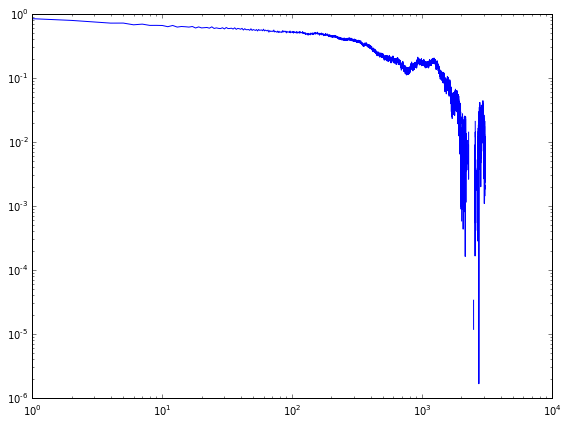

In [87]:
plt.figure(figsize=largefig)
plt.loglog(Phi_ac[n])

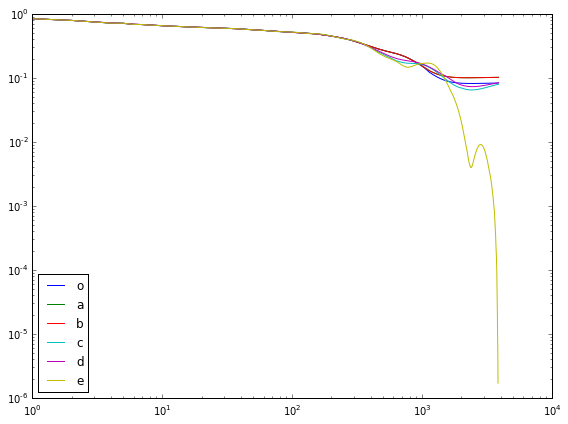

In [269]:
n = 416
plt.figure(figsize=largefig)
plt.loglog(np.column_stack([Phi_ac[n],
                            Phi_ac_vg[n],
                            Phi_ac_vg_a[n], Phi_ac_vg_b[n],
                            Phi_ac_vg_c[n], Phi_ac_vg_d[n],
                            Phi_ac_vg_e[n],
                           ]))
plt.legend('o a b c d e'.split(), loc='best')
#plt.ylim(.06, .2)
#plt.xlim(100,None)

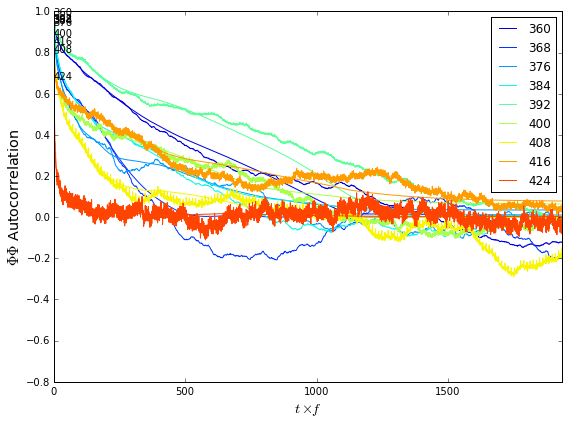

In [251]:
# Plot the Phi-Phi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n in [360, 368, 376, 384, 392, 400, 408, 416, 424]:
    Pac = Phi_ac[n]
    tf = np.arange(len(Pac))#*freq/fps
    try:
        plt.plot(tf, Phi_ac[n], color=col((n-350)/100), label=str(n))
        plt.plot(tf, np.maximum(Phi_ac_vg[n],0), color=col((n-350)/100))
        plt.text(tf[1],Phi_ac_vg[n][1], str(n)) 
    except KeyError:
        continue
    #plt.plot(tf, np.maximum(Pac,0), color=col(density[margin][n]), alpha=.8)
plt.legend(loc='best')
plt.yscale('linear')
plt.xscale('linear')
#plt.ylim(0, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Phi\Phi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "phi_autocorr.pdf")

a, x0, sig = [  1.61997977e+02   7.02380592e-01   8.55275130e-02]


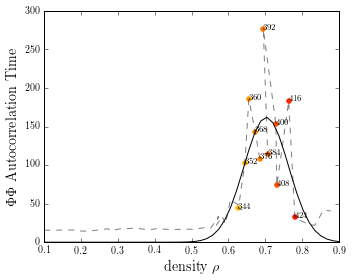

In [54]:
save = True
rc('text', usetex=save)
ns = ns_all

Phi_ac_fortime = Phi_ac
plt.figure(figsize=smallfig)
Phi_time = np.array([corr.decay_scale(Phi_ac_fortime[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Phi_time)[26:37]:
    plt.scatter(density[margin][n], tau, color=col(density[margin][n]))
    plt.text(density[margin][n], np.nan_to_num(tau), '{:d}'.format(n), fontsize='small')
plt.plot(densities[margin], Phi_time, 'k--', alpha=0.5)
p_phi, _ = curve_fit(corr.gauss, densities[margin][np.isfinite(Phi_time)], Phi_time[np.isfinite(Phi_time)],
                     p0 = [100, .7, .2])
print 'a, x0, sig =', p_phi
plt.plot(np.linspace(0.1,0.9), corr.gauss(np.linspace(0.1,0.9), *p_phi), 'k')
plt.xlim(.1,.9)
plt.ylim(0, None)
plt.xlabel(r'density $\rho$', fontsize='x-large')
plt.ylabel(r'$\Phi\Phi$ Autocorrelation Time', fontsize='x-large')
if save: plt.savefig(savedir+'phiphi_time.pdf')

In [32]:
if True:
    Psi_npz = np.load(locdir+'psi_t.npz')
    Psi = {n: Psi_npz[str(n)] for n in ns_all}
else:
    Psi = {}
    for n in ns_all:
        data, trackids, odata, omask = load_data(n)
        Psi[n] = np.array([corr.pair_angle_op(
                                   *corr.pair_angles(d[['x','y']].view((float,2)).copy(), 4,
                                                     margin=2, dub=2*S)[:2]
                           , m=4)[0]
                  for d, o in it.izip(helpy.splitter(data[omask], data['f'][omask]),
                                      helpy.splitter(odata[omask], data['f'][omask]))])
    np.savez(locdir + 'psi_t.npz', **{str(n): Psi[n] for n in ns_all})

In [88]:
np.savetxt(locdir+'all_psi_t', np.column_stack([Psi[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [33]:
Psi_ac = { n: corr.autocorr(P) for n, P in Psi.iteritems()}

In [254]:
np.column_stack([Phi_ac[n] for n in ns_all]).shape

(3864, 42)

In [255]:
np.savetxt(locdir+'all_psi_psi_newcorrfunc', np.column_stack([Psi_ac[n] for n in ns_all]),
          header=' '.join(map(str, ns_all)))

In [215]:
# Gaussian smooth (low-pass)
Psi_ac_lp = {}
for n, Pac in Psi_ac.iteritems():
    g = [gaussian_filter(Pac, sig, mode='constant', cval=Pac[sig]) for sig in (1, 10, 100, 1000)]
    Psi_ac_lp[n] = np.choose(np.repeat([0,1,2,3], [10,90,900,len(Pac)-1000]), g)

In [34]:
Psi_ac_vg = { n: corr.vary_gauss(Pac, .2*np.arange(len(Pac))+.001*np.arange(len(Pac))**2)
             for n, Pac in Psi_ac.iteritems()}

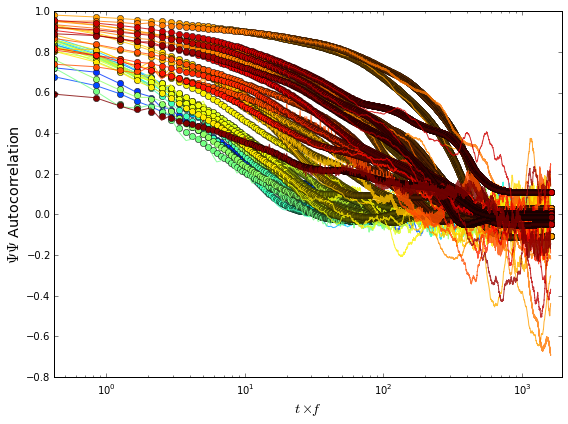

In [257]:
# Plot the Psi-Psi Autocorrelation
save = False
rc('text', usetex=save)
plt.figure(figsize=smallfig if save else largefig)
for n in ns_all:
    Pac = Psi_ac[n]
    tf = np.arange(len(Pac))*freq/fps
    plt.plot(tf, Psi_ac_vg[n], 'o', color=col(density[margin][n]))
    plt.plot(tf, Pac, color=col(density[margin][n]), alpha=.8)
plt.yscale('linear')
plt.xscale('log')
#plt.ylim(.1, 1)
plt.xlim(freq/fps, nframes/4)
plt.ylabel(r'$\Psi\Psi$ Autocorrelation', fontsize='x-large')
plt.xlabel(r'$t\times f$', fontsize='x-large')
if save: plt.savefig(savedir + "psi_autocorr.pdf")

a, x0, sig = [ 145.97203488    0.77059255    0.16774112]


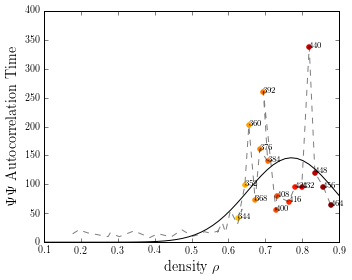

In [53]:
save = True
rc('text', usetex=save)

Psi_ac_fortime = Psi_ac_vg
plt.figure(figsize=smallfig)
ns = ns_all
Psi_time = np.array([corr.decay_scale(Psi_ac_fortime[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Psi_time)[26:]:
    plt.scatter(density[margin][n], tau, color=col(density[margin][n]))
    plt.text(density[margin][n], np.nan_to_num(tau), '{:d}'.format(n), fontsize='small')
plt.plot(densities[margin], Psi_time, 'k--', alpha=0.5)
p_psi, _ = curve_fit(corr.gauss, densities[margin][np.isfinite(Psi_time)], Psi_time[np.isfinite(Psi_time)],
                     p0=[800, .7, .2])
print 'a, x0, sig =', p_psi
plt.plot(np.linspace(0.1,0.9), corr.gauss(np.linspace(0.1,0.9), *p_psi), 'k')
plt.xlim(.1,.9)
plt.ylim(0, None)
plt.xlabel(r'density $\rho$', fontsize='x-large')
plt.ylabel(r'$\Psi\Psi$ Autocorrelation Time', fontsize='x-large')
if save: plt.savefig(savedir+'psipsi_time.pdf')

(0, 900.0)

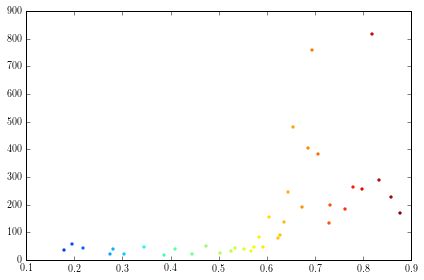

In [173]:
for n in ns_all:
    #tau_v = corr.decay_scale(Psi_ac_vg[n], tf, smooth='', method='inverse_mean', rectify=False)
    #tau_m = corr.decay_scale(np.maximum(Psi_ac_vg[n],0), tf, smooth='', method='mean', rectify=False)
    tau_i = corr.decay_scale(Psi_ac_vg[n], tf, smooth='', method='int', rectify=False)
    dens = density[margin][n]
    plt.scatter(dens, tau_i, marker='.', color=col(dens))
    #plt.scatter(dens, tau_m, marker='*', color=col(dens))
    #plt.scatter(dens, tau_v, marker='+', color=col(dens))    
plt.xlim(.1,.9)
plt.ylim(0, None)

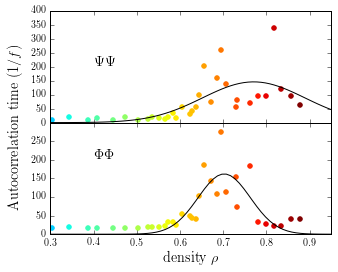

In [52]:
save = True
rc('text', usetex=True)
ns = ns_all
figsize = (smallfig[0]*1.5, smallfig[1])
fig = plt.figure(figsize=smallfig)
gs = gridspec.GridSpec(2,1)
gs.update(hspace=0, left=.12)
axt = fig.add_subplot(gs[0])
axb = fig.add_subplot(gs[1])
axphi = axb
axpsi = axt

Phi_time = np.array([corr.decay_scale(Phi_ac[n], smooth='', method='int') for n in ns]) * freq/fps
Psi_time = np.array([corr.decay_scale(Psi_ac_vg[n], smooth='', method='int') for n in ns]) * freq/fps
for n, tau in zip(ns, Phi_time):
    axphi.scatter(density[margin][n], tau, color=col(density[margin][n]))
for n, tau in zip(ns, Psi_time):
    axpsi.scatter(density[margin][n], tau, color=col(density[margin][n]))
#axphi.plot(densities[margin], Phi_time, 'k--', alpha=0.5)
#axpsi.plot(densities[margin], Psi_time, 'k--', alpha=0.5)
n_cont = np.linspace(0,1,100)
axphi.plot(n_cont, corr.gauss(n_cont, *p_phi), 'k')
axpsi.plot(n_cont, corr.gauss(n_cont, *p_psi), 'k')

axt.set_ylim(0, None)
axphi.text(0.4, 200, r'$\Phi\Phi$', fontsize='x-large')
axpsi.text(0.4, 200, r'$\Psi\Psi$', fontsize='x-large')
axt.set_xticklabels([])
axb.set_xlabel(r'density $\rho$', fontsize='x-large')  
xlim = (.3, .95)
axt.set_xlim(xlim)
axb.set_xlim(xlim)
axb.set_ylim(0, None)
axb.set_yticklabels(range(0,300,50))
fig.text(0, .75, "Autocorrelation time ($1/f$)", rotation='vertical', fontsize='x-large')
if save: plt.savefig(savedir+'autocorr_time.pdf')